In [10]:
import pyspark

import sys

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

In [11]:
import findspark

### pyspark 做lindemann分析

此处全部用numpy数组的方式转换成spark RDD对象进行数据的处理

TODO: 如何使用spark 分布式的读取Numpy数组是可以优化的地方

In [12]:
from MDAnalysis import Universe
import numpy as np
from MDAnalysis.lib.distances import distance_array


请在此处填写需要进行lindemann分析的轨迹文件 和相关参数

In [13]:
xyz_file = "./traj.xyz"
ana_range = (0, ) #轨迹的start, stop, step

In [17]:
uni = Universe("./traj.xyz")
uni.transfer_to_memory()
positions = uni.trajectory.get_array()
positions = positions[:,:40,:] # 取前40个原子, 

In [18]:
sc = SparkContext.getOrCreate()

### 并行化  running welford算法的实现
此处主要为RDD数据之间的编排
具体算法看map的函数

In [19]:
slices = 10

In [20]:
#partion_frames = sc.parallelize(positions, slices).mapPartitions(calc_partion_frames)

请先import 一下notebook后面的方法

In [29]:
slices = 10


#这两个需要提前计算 不能用dag, 使用的广播处理
partion_frames = sc.parallelize(positions, slices).mapPartitions(calc_partion_frames).collect()
partion_frames_broad = sc.broadcast(partion_frames)
#partion_frames_agg = [sum(partion_frames_broad.value[:i+1])-1 for i in range(len(partion_frames_broad.value))]
#partion_frames_agg_broad = sc.broadcast(partion_frames_agg)

partion_means = sc.parallelize(positions, slices).mapPartitions(calc_partion_mean)#.collect()
partion_vars = sc.parallelize(positions, slices).mapPartitions(calc_partion_var)#.collect()


In [33]:
#问题变成了 如何低开销的方式获得last_vars和means

In [34]:
def get_final_frame(partiondata):
    return [partiondata[-1]]
partion_means.mapPartitions(slices)

partion_last_means = partion_means.mapPartitions(get_final_frame).collect()
partion_last_vars = partion_vars.mapPartitions(get_final_frame).collect()

partion_last_means_broad = sc.broadcast(partion_last_means)
partion_last_vars_broad = sc.broadcast(partion_last_vars)

In [35]:
partion_info = partion_means.zip(partion_vars).zipWithIndex()

In [36]:
from functools import partial

recovered_means =partion_info.map(
    partial(recover_per_mean,
            partion_frames_broad=partion_frames_broad, 
            partion_last_means_broad=partion_last_means_broad,))

In [37]:
recovered_vars = partion_info.map(partial(recover_per_var, 
                                     partion_frames_broad=partion_frames_broad, 
                                     partion_last_means_broad=partion_last_means_broad, 
                                     partion_last_vars_broad=partion_last_vars_broad))#.collect()

In [39]:
# 到此 随时间变化的方差和平均(累积平均)计算完成

### 最终lindex数值的求解

In [40]:
def get_lindex(zipped_var_mean_idx):
    
    mean = zipped_var_mean_idx[0][0]
    var = zipped_var_mean_idx[0][1]
    cur_idx = zipped_var_mean_idx[1]
    iframe = cur_idx
    
    return np.divide(np.sqrt(np.divide(var, iframe)), 
                             mean)
    
lindex  = recovered_means.zip(recovered_vars).zipWithIndex().map(get_lindex)

In [41]:
lindex = lindex.collect()

/tmp/ipykernel_573157/2800759032.py:8: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_573157/2800759032.py:8: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_573157/2800759032.py:8: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_573157/2800759032.py:8: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_573157/2800759032.py:8: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_573157/2800759032.py:8: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_573157/2800759032.py:8: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_573157/2800759032.py:8: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_573157/2800759032.py:8: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_573157/2800759032.py:8: RuntimeWarning: invalid value encountered in divide


In [42]:
# #pickle 化数据输出与读取
#读取的时候把顺序打乱了 好奇怪

# lindex.saveAsPickleFile("./lindemann.out")
# lindemann_out = sc.pickleFile("./lindemann.out/")
# lindemann_out.collect()

In [43]:
#lindex = lindemann_out.collect()
lindex = np.array(lindex)

lindex_atoms = np.array([np.nanmean(i, axis=1) for i in lindex])
lindex_frames = np.array([np.mean(np.nanmean(i, axis=1)) for i in lindex])

/tmp/ipykernel_573157/1023770531.py:4: RuntimeWarning: Mean of empty slice
  lindex_atoms = np.array([np.nanmean(i, axis=1) for i in lindex])
/tmp/ipykernel_573157/1023770531.py:5: RuntimeWarning: Mean of empty slice
  lindex_frames = np.array([np.mean(np.nanmean(i, axis=1)) for i in lindex])


### 一些数据的可视化

In [44]:
import matplotlib.pyplot as plt

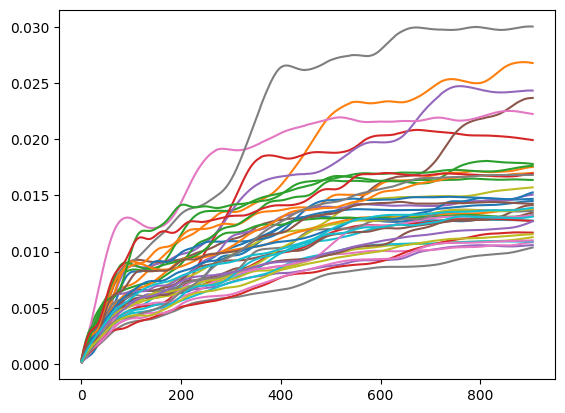

In [45]:
# 查看轨迹中Lindex情况

atom_num = lindex_atoms.shape[1]

for i in range(atom_num):
    lindex_per_atom = lindex_atoms[:,i]
    plt.plot(lindex_per_atom)

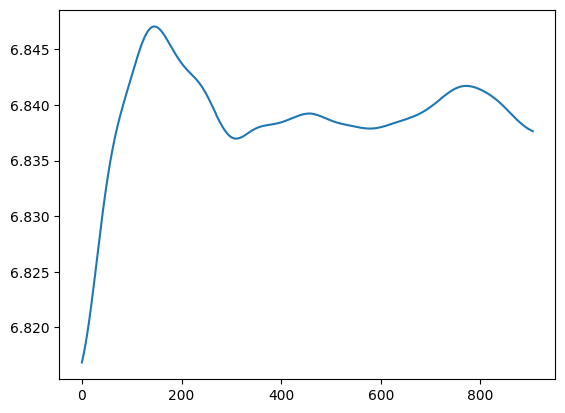

In [50]:
# 累积平均情况
mean_rec = np.array(recovered_means.collect()).mean(axis=1).mean(axis=1)
plt.plot(mean_rec)

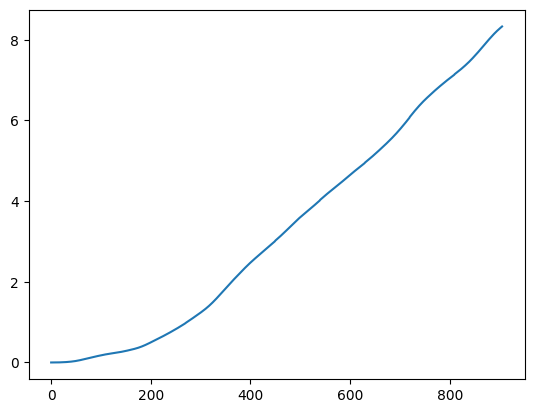

In [54]:
# 方差情况
var_rec = np.array(recovered_vars.collect()).mean(axis=1).mean(axis=1)
plt.plot(var_rec,)

#### 一些用于map的函数，请先运行它们

In [22]:
def recover_per_mean(partion_info, partion_frames_broad, partion_last_means_broad):
    
    #得到广播的值
    partion_frames = partion_frames_broad.value
    partion_last_means = partion_last_means_broad.value

    partion_frames_agg = [sum(partion_frames[:i+1])-1 for i in range(len(partion_frames))]
    
    #怎么获取当前帧数的idx?
    cur_mean = partion_info[0][0]
    cur_idx =  partion_info[1]
    
    part_idx = sum(np.array(partion_frames_agg)<cur_idx)
    
    latter_tail_mean = partion_last_means[:part_idx]
    latter_slice_frames = [item+1 for item in partion_frames[:part_idx]] #idx与 当前帧的数量的区别
    latter_frames_sum = int(np.sum(latter_slice_frames))
    #latter_frames_sum = partion_frames_agg[part_idx-1]+1 if part_idx!=0 else 0
    

    #此处应该是处理某一帧中的数据 [atoms, atoms] 形状
    #这个指针的还原还是很重要的
    k = cur_idx if cur_idx <= partion_frames_agg[0] else cur_idx - partion_frames_agg[part_idx-1]-1
#for test
#     if cur_idx ==30 or cur_idx==120 or cur_idx ==190: 
#         print(len(latter_tail_mean))
#         print("latter_slice_frames", latter_slice_frames)
#         print('latter_frame_sum', latter_frames_sum)
#         print("cur_idx: ", cur_idx)
#         print("k: ", k)

    cur_frame_nums = latter_frames_sum + (k+1)
    sample_len = np.array(latter_slice_frames + [k+1]) #[n1, n2, n3, ... k]
    ratio_mean = np.array(latter_slice_frames + [k+1])/cur_frame_nums #[n1, n2, n3, ... k]/(sum(n1+nk-1)+k)

    #calc mean
    tail_mean = np.array(latter_tail_mean + [cur_mean]) #当前的 完整的分块的mean
    true_mean = [tail_mean[idx]*ratio_mean[idx] for idx in range(len(tail_mean))] #shape是什么？ nk个 [[atoms, atoms],[atoms, atoms]]
    true_mean = np.sum(true_mean, axis=0) #这里的sum是什么意义？: sum的一些中间量最后的ture_mean的shape还是atoms,atoms
    
    #print(true_mean.shape)
    
    return true_mean

In [23]:
def recover_per_var(partion_info, partion_frames_broad, partion_last_means_broad, partion_last_vars_broad):
    
    #得到广播的值
    partion_frames_agg = partion_frames_broad.value
    partion_last_means = partion_last_means_broad.value
    partion_last_vars = partion_last_vars_broad.value
    
    partion_frames_agg = [sum(partion_frames[:i+1])-1 for i in range(len(partion_frames))]
    
    #怎么获取当前帧数的idx?
    cur_mean = partion_info[0][0]
    cur_var = partion_info[0][1]
    cur_idx =  partion_info[1]
    
    part_idx = sum(np.array(partion_frames_agg)<cur_idx)
    
    latter_tail_mean = partion_last_means[:part_idx]
    latter_tail_var = partion_last_vars[:part_idx]
    latter_slice_frames = [item+1 for item in partion_frames[:part_idx]] #idx与 当前帧的数量的区别
    latter_frames_sum = int(np.sum(latter_slice_frames))
    

    #此处应该是处理某一帧中的数据 [atoms, atoms] 形状
    #这个指针的还原还是很重要的
    k = cur_idx if cur_idx <= partion_frames_agg[0] else cur_idx - partion_frames_agg[part_idx-1]-1

    cur_frame_nums = latter_frames_sum + (k+1)
    sample_len = np.array(latter_slice_frames + [k+1]) #[n1, n2, n3, ... k]
    ratio_mean = np.array(latter_slice_frames + [k+1])/cur_frame_nums #[n1, n2, n3, ... k]/(sum(n1+nk-1)+k)

    #calc mean
    tail_mean = np.array(latter_tail_mean + [cur_mean]) #当前的 完整的分块的mean
    true_mean = [tail_mean[idx]*ratio_mean[idx] for idx in range(len(tail_mean))] #shape是什么？ nk个 [[atoms, atoms],[atoms, atoms]]
    true_mean = np.sum(true_mean, axis=0) #这里的sum是什么意义？: sum的一些中间量最后的ture_mean的shape还是atoms,atoms
    
    #print(true_mean.shape)
    
    tail_var = np.array(latter_tail_var + [cur_var])    #几个V的求和  和当前的V
    tail_unknown_factors = np.r_[np.square(true_mean - tail_mean)[:part_idx], [np.square(true_mean - cur_mean)]]
    #val_1 =  np.array([tail_var[idx]*1 for idx in range(len(tail_var))])
    val_1 = tail_var
    val_1 = np.sum(val_1, axis=0)
    val_2 =  np.array([tail_unknown_factors[idx]*sample_len[idx] for idx in range(len(tail_unknown_factors))])
    val_2 = sum(val_2, )
    true_var = val_1 + val_2 #sum to var
    
    return true_var

In [26]:
def calc_partion_frames(frames):
    
    return np.array([len(list(frames))])

In [27]:
def calc_partion_var(frames, box=None):
    
    #we called frame as (natoms, 3) size then frames will be (n, natoms ,3).
    
    #迭代器是有一定优化的 解开迭代器会导致什么？
    frames = list(frames)
    natoms = len(frames[0])
    #nframes = len(frames)

    # array_distance.shape: (natoms, natoms) far bigger than frames 

    series_mean = np.empty((0, natoms, natoms), dtype=float)
    series_var = np.empty((0, natoms, natoms), dtype=float)

    array_mean = np.zeros((natoms, natoms))
    array_var = np.zeros((natoms, natoms))
    
    #print(len(frames))
    
    for fr_idx, frame in enumerate(frames):
        #print(fr_idx)
        array_distance = distance_array(frame, frame, box=box)

        for i in range(natoms):
            for j in range(i + 1, natoms):
                xn = array_distance[i, j]
                mean = array_mean[i, j]
                var = array_var[i, j]
                delta = xn - mean
                # update mean
                array_mean[i, j] = mean + delta / (fr_idx + 1)
                # update variance
                array_var[i, j] = var + delta * (xn - array_mean[i, j])

        for i in range(natoms):
            for j in range(i + 1, natoms):
                array_mean[j, i] = array_mean[i, j]
                array_var[j, i] = array_var[i, j]
        
            
        series_mean = np.r_[series_mean, [array_mean]]
        series_var = np.r_[series_var, [array_var]]
    
    return series_var#, series_mean

In [28]:
def calc_partion_mean(frames, box=None):
    
    #we called frame as (natoms, 3) size then frames will be (n, natoms ,3).
    
    #迭代器是有一定优化的 解开迭代器会导致什么？
    frames = list(frames)
    natoms = len(frames[0])
    #nframes = len(frames)

    # array_distance.shape: (natoms, natoms) far bigger than frames 

    series_mean = np.empty((0, natoms, natoms), dtype=float)
    series_var = np.empty((0, natoms, natoms), dtype=float)

    array_mean = np.zeros((natoms, natoms))
    #array_var = np.zeros((natoms, natoms))
    
    #print(len(frames))
    
    for fr_idx, frame in enumerate(frames):
        #print(fr_idx)
        array_distance = distance_array(frame, frame, box=box)

        for i in range(natoms):
            for j in range(i + 1, natoms):
                xn = array_distance[i, j]
                mean = array_mean[i, j]
                #var = array_var[i, j]
                delta = xn - mean
                # update mean
                array_mean[i, j] = mean + delta / (fr_idx + 1)
                # update variance
                #array_var[i, j] = var + delta * (xn - array_mean[i, j])

        for i in range(natoms):
            for j in range(i + 1, natoms):
                array_mean[j, i] = array_mean[i, j]
                #array_var[j, i] = array_var[i, j]
        
            
        series_mean = np.r_[series_mean, [array_mean]]
        #series_var = np.r_[series_var, [array_var]]

    return series_mean